In [11]:
import numpy as np
from Bio import SeqIO
import os
import pandas as pd
import torch
import seaborn as sns
import math
import scipy.stats as stats
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from numpy import trapz
from sklearn.metrics import auc
from pathlib import Path
sns.set(font_scale=1.6, style="ticks")

In [12]:
runs_folder = Path("../../../runs/flu_ah3n2_countries")
data_folder = Path("../../../data/gisaid/flu/ha_processed_countries")
saving_dir = Path("figs")

saving_dir.mkdir(parents=True, exist_ok=True)

In [13]:
subtype = "a_h3n2"
for year in list(range(2016, 2019)):
    all_test_path = data_folder / ("2003-10_to_2023-04_6M/a_h3n2/human_minBinSize10_minLen553_maxLen566_location_region2_bins/%d.fasta" % ((year - 2018) * 2 + 30))
    location_to_count = defaultdict(int)
    records = SeqIO.parse(all_test_path, "fasta")
    for record in records:
        description = record.description.split()[1]
        desc = {x.split("=")[0]: x.split("=")[1] for x in description.split("|")}
        location = desc["location"]
        location_to_count[desc["location"]] += round(float(desc["freq"]) * int(desc["bin_size"]))

ERROR! Session/line number was not unique in database. History logging moved to new session 5


# NLL & revNLL

In [14]:
subtype = "a_h3n2"
locations = ( 
    "north_america/united_states", 
    "north_america/canada",
    "europe/france",
    "europe/germany",
    "europe/russian_federation",
    "europe/spain",
    "europe/united_kingdom",
    "asia/china",
    "asia/japan",
    "oceania/australia"
)

def get_nlls(df):
    m = df.pivot(index='src_id', columns='src_time', values='prediction')
    m = torch.tensor(m.to_numpy())
    nlls = - (torch.logsumexp(-m, dim=-1) - math.log(m.size(1))) 
    freqs = torch.tensor(df.pivot(index='src_id', columns='src_time', values='freq').to_numpy())
    if torch.all(torch.isnan(freqs)):
        freqs = torch.ones(freqs.size()) / freqs.size(0)
    freqs = torch.mean(freqs, dim=1)
    freqs = freqs / torch.sum(freqs)
    tok_num = torch.tensor(df.pivot(index='src_id', columns='src_time', values='token_num').to_numpy())
    assert torch.all(tok_num == tok_num[:,:1])
    tok_num = tok_num[:, 0].float()    
    nll = torch.sum(freqs * nlls) / torch.sum(freqs * tok_num) # 
    perplexity = torch.exp(nll)
    return nll, perplexity

def read_all_nll(path, test_path):
    if isinstance(path, Path):
        if not os.path.exists(path):
            print("path not exist", path)
            return None
        
        records = SeqIO.parse(test_path, "fasta")
        id2location = dict()
        for record in records:
            desc = record.description.split()[1].split("|")
            desc = {x.split("=")[0]: x.split("=")[1] for x in desc}
            id2location[record.id] = desc["location"]

        df = pd.read_csv(path)
        locations = []
        for src_id in df["src_id"]:
            locations.append(id2location[src_id])
        df["location"] = locations
        return df
    elif isinstance(path, dict):
        all_dfs = []
        for location, p in path.items(): 
            if not os.path.exists(p):
                print("path not exists",p)
            df = pd.read_csv(p)
            locations = [location] * len(df)
            df["location"] = locations
            all_dfs.append(df)
        return pd.concat(all_dfs)
    else:
        print("cannot recognize path:", path)
        
        
all_nll_results = []
            
testing_years = list(range(2016, 2019))
    
for test_rev_dir in ("test_rev_seed_1005", "test_rev_seed_1213", "test_rev_seed_529"):
    print(">>>", test_rev_dir)

    for year in testing_years:
        print(year)
        nll_results = defaultdict(list)
        all_test_path = data_folder / ("2003-10_to_2023-04_6M/a_h3n2/human_minBinSize10_minLen553_maxLen566_location_region2_bins/%d.fasta" % ((year - 2018) * 2 + 30))
        for temperature in (0.2, 0.4, 0.6, 0.8, 1.0):
            name2nll_path = {
                    "Add_Embed": runs_folder / (f"2003-10_to_{year}-02_2M/concat/test/temp_{temperature}/test_results.csv"),
                    "G2L/random": runs_folder / f"2003-10_to_{year}-02_2M/transmission_hierachy/country_to_continent/random_2_6-10/test/temp_{temperature}/lightning_logs/version_0/test_results.csv",
                    "G2L/clustering": runs_folder / f"2003-10_to_{year}-02_2M/transmission_hierachy/country_to_continent/agg_complete_2/test/temp_{temperature}/lightning_logs/version_0/test_results.csv",
                    "G2G/random": runs_folder / f"2003-10_to_{year}-02_2M/transmission_hierachy/continent_to_continent/random_2_6-10/test/temp_{temperature}/lightning_logs/version_0/test_results.csv",
                    "G2G/clustering": runs_folder / f"2003-10_to_{year}-02_2M/transmission_hierachy/continent_to_continent/agg_complete_2/test/temp_{temperature}/lightning_logs/version_0/test_results.csv",

                }
            model2nll = dict()
            for model in name2nll_path:
                model2nll[model] = read_all_nll(name2nll_path[model], all_test_path)

            for location in locations:
                continent, country = location.split("/")

                name2rev_nll_path = {
                    "G2G/clustering": runs_folder / f"2003-10_to_{year}-02_2M/transmission_hierachy/continent_to_continent/agg_complete_2/{test_rev_dir}/{continent}_{country}/temp_{temperature}/lightning_logs/version_0/test_results.csv",
                    "G2L/clustering": runs_folder / f"2003-10_to_{year}-02_2M/transmission_hierachy/country_to_continent/agg_complete_2/{test_rev_dir}/{continent}_{country}/temp_{temperature}/lightning_logs/version_0/test_results.csv",
                    "G2G/random": runs_folder / f"2003-10_to_{year}-02_2M/transmission_hierachy/continent_to_continent/random_2_6-10/{test_rev_dir}/{continent}_{country}/temp_{temperature}/lightning_logs/version_0/test_results.csv",
                    "G2L/random": runs_folder / f"2003-10_to_{year}-02_2M/transmission_hierachy/country_to_continent/random_2_6-10/{test_rev_dir}/{continent}_{country}/temp_{temperature}/lightning_logs/version_0/test_results.csv",
                    "Add_Embed": runs_folder / f"2003-10_to_{year}-02_2M/concat/{test_rev_dir}/{continent}_{country}/temp_{temperature}/lightning_logs/version_0/test_results.csv",
                } 

                for name, _path in name2nll_path.items():
                    our_model_path_rev_nll = name2rev_nll_path[name]
                    if os.path.exists(our_model_path_rev_nll) and model in model2nll:
                        df = model2nll[name]
                        nll, ppl = get_nlls(df[df["location"] == location])
                        df = pd.read_csv(our_model_path_rev_nll)
                        rev_nll, rev_ppl = get_nlls(df)

                        nll_results["NLL"].append(nll.item())
                        nll_results["PPL"].append(ppl.item())
                        nll_results["reverse NLL"].append(rev_nll.item())
                        nll_results["reverse PPL"].append(rev_ppl.item())
                        nll_results["temperature"].append(temperature)
                        nll_results["location"].append(location)
                        nll_results["model"].append(name)
                        nll_results["oracle"].append(test_rev_dir)

                    else:
                        if not os.path.exists(our_model_path_rev_nll):
                            print(our_model_path_rev_nll)

                        if model not in model2nll:
                            print(model)

        nll_results = pd.DataFrame(nll_results)
        nll_results["year"] = [year] * len(nll_results)

        location_to_count = defaultdict(int)
        records = SeqIO.parse(all_test_path, "fasta")
        for record in records:
            description = record.description.split()[1]
            desc = {x.split("=")[0]: x.split("=")[1] for x in description.split("|")}
            location = desc["location"]
            location_to_count[desc["location"]] += round(float(desc["freq"]) * int(desc["bin_size"]))
        nll_results["bin_size"] = [ location_to_count[x] for x in nll_results["location"] ]

        all_nll_results.append(nll_results)

all_nll_results = pd.concat(all_nll_results)
print(all_nll_results)



>>> test_rev_seed_1005
2016
2017
2018
>>> test_rev_seed_1213
2016
2017
2018
>>> test_rev_seed_529
2016
2017
2018
          NLL       PPL  reverse NLL  reverse PPL  temperature  \
0    0.227351  1.255271     0.008398     1.008434          0.2   
1    0.232583  1.261856     0.007995     1.008027          0.2   
2    0.240079  1.271350     0.007781     1.007811          0.2   
3    0.221316  1.247718     0.007813     1.007844          0.2   
4    0.224226  1.251354     0.008182     1.008215          0.2   
..        ...       ...          ...          ...          ...   
245  0.057053  1.058712     0.022109     1.022355          1.0   
246  0.061218  1.063130     0.019722     1.019918          1.0   
247  0.060010  1.061847     0.019543     1.019735          1.0   
248  0.056063  1.057665     0.019905     1.020104          1.0   
249  0.058015  1.059730     0.018725     1.018901          1.0   

                        location           model              oracle  year  \
0    north_ameri

In [15]:
orig_all_nll_results = all_nll_results

In [16]:
all_nll_results = orig_all_nll_results[orig_all_nll_results["bin_size"] >= 100]

In [17]:
all_nll_results

,NLL,PPL,reverse NLL,reverse PPL,temperature,location,model,oracle,year,bin_size
0,0.227351,1.255271,0.008398,1.008434,0.2,north_america/united_states,Add_Embed,test_rev_seed_1005,2016,3573
1,0.232583,1.261856,0.007995,1.008027,0.2,north_america/united_states,G2L/random,test_rev_seed_1005,2016,3573
2,0.240079,1.271350,0.007781,1.007811,0.2,north_america/united_states,G2L/clustering,test_rev_seed_1005,2016,3573
3,0.221316,1.247718,0.007813,1.007844,0.2,north_america/united_states,G2G/random,test_rev_seed_1005,2016,3573
4,0.224226,1.251354,0.008182,1.008215,0.2,north_america/united_states,G2G/clustering,test_rev_seed_1005,2016,3573
...,...,...,...,...,...,...,...,...,...,...
245,0.057053,1.058712,0.022109,1.022355,1.0,oceania/australia,Add_Embed,test_rev_seed_529,2018,452
246,0.061218,1.063130,0.019722,1.019918,1.0,oceania/australia,G2L/random,test_rev_seed_529,2018,452
247,0.060010,1.061847,0.019543,1.019735,1.0,oceania/australia,G2L/clustering,test_rev_seed_529,2018,452
248,0.056063,1.057665,0.019905,1.020104,1.0,oceania/australia,G2G/random,test_rev_seed_529,2018,452


In [18]:
NLL_KEY = "NLL"
REV_NLL_KEY ="reverse NLL"

def get_summary(df, keys=("model", "temperature", "year"), weighted_average=True, nll_key=NLL_KEY, rev_nll_key=REV_NLL_KEY):
    summary_nll_results = defaultdict(list)
    for x in zip(*(df[key] for key in keys)):
        _df = df
        for i, key in enumerate(keys):
            _df = _df[_df[key] == x[i]]
        
        if weighted_average:
            ave_nll = np.sum(_df["bin_size"] * _df[nll_key]) / np.sum(_df["bin_size"])
            ave_rev_nll = np.sum(_df["bin_size"] * _df[rev_nll_key]) / np.sum(_df["bin_size"])
        else:
            ave_nll = np.mean(_df[nll_key])
            ave_rev_nll = np.mean(_df[rev_nll_key])
        
        for i, key in enumerate(keys):
            summary_nll_results[key].append(x[i])
        summary_nll_results[nll_key].append(ave_nll)
        summary_nll_results[rev_nll_key].append(ave_rev_nll)
        summary_nll_results["toal_sample_size"].append(np.sum(_df["bin_size"]))

    summary_nll_results = pd.DataFrame(summary_nll_results)
    summary_nll_results = summary_nll_results.drop_duplicates()
    return summary_nll_results

In [19]:
def plot(summary_summary_df, fig_title, fig_save_path):
    plt.xscale('log')
    plt.yscale('log')

    plt.rcParams['lines.markersize'] = 15
    
    ori_our_model_name_1 = "Transmission(G2G)"
    our_model_name_1 = r'$\bf{Transmission(G2G)}$' # r'$\bf{Bold}$'
    
    ori_our_model_name_2 = "Transmission(G2L)"
    our_model_name_2 = r'$\bf{Transmission(G2L)}$' # r'$\bf{Bold}$'
    
    summary_summary_df["model"] = [
        x if (x != ori_our_model_name_1 and x != ori_our_model_name_2) 
        else r'$\bf{%s}$' % x for x in summary_summary_df["model"]]

    
    models = list(set(summary_summary_df["model"]))
    models.sort()
    style_dict = {}
    for model in models:
        if model == our_model_name_1 or model == our_model_name_2:
            style_dict[model] = ""
        else:
            style_dict[model] = (2,2)
    
    style_order =  [our_model_name_1, our_model_name_2,  'Add_Embed', 'Param_share', 'Finetune', 'Prepend', 'LoRA', 'Global']

    # color dict
    palette_light = sns.color_palette("Set2", n_colors=12) # pastel
    palette_dark = sns.color_palette("hls", n_colors=12)
    color_dict = {}

    if our_model_name_1 in models:
        models.remove(our_model_name_1)
    if our_model_name_2 in models:
        models.remove(our_model_name_2)
    
    for i, model in enumerate(models):
        color_dict[model] = palette_light[i]
    color_dict[our_model_name_1] = palette_dark[5]
    color_dict[our_model_name_2] = palette_dark[0]

    ax = sns.lineplot(summary_summary_df, x="NLL", y="reverse NLL", hue="model", markers=True, # marker='o', 
                      sort=False,style="model",lw=2.5, dashes=style_dict,palette=color_dict,style_order=style_order) # , size=20 ,linewidth = 1.5

    
    ax.set_title(fig_title)
    ax.set_xlabel("NLL")
    ax.set_ylabel("reverse NLL")

    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    

    plt.savefig(fig_save_path, format='pdf', bbox_inches='tight')

    plt.show()

['G2G/clustering', 'G2G/random', 'G2L/clustering', 'G2L/random', 'Add_Embed']


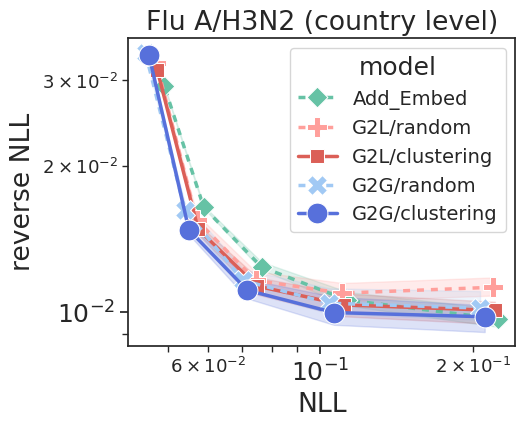

In [20]:
import matplotlib.ticker as ticker

min_count=200 

summary_summary_df = get_summary(all_nll_results[all_nll_results["bin_size"]>=min_count], keys=("model", "temperature", "oracle"), weighted_average=False)

plt.xscale('log')
plt.yscale('log')


plt.rcParams['figure.figsize'] = 5, 4
plt.rcParams['lines.markersize'] = 15

models = list(set(summary_summary_df["model"]))
models.sort()

if "Add_Embed" in models:
    models.remove("Add_Embed")
    models = models + ["Add_Embed"]

print(models)
style_dict = {}
for model in models:
    if model == "G2G/clustering" or model == "G2L/clustering":
        style_dict[model] = ""
    else:
        style_dict[model] = (2,2)

style_order = models

palette_light = sns.color_palette("pastel", n_colors=8) # n_colors=8
palette_dark = sns.color_palette("hls", n_colors=8)
palette_pink = sns.color_palette("ch:s=.4,r=0.2,dark=0.6", n_colors=3)
palette_blue = sns.color_palette("ch:start=.3,rot=-.3,dark=0.5", n_colors=3)[1:]

color_dict = {}

for i, model in enumerate([x for x in models if "G2L" in x and "cluster" not in x]):
    color_dict[model] = palette_light[3::2][i]
    
for i, model in enumerate([x for x in models if "G2G" in x and "cluster" not in x]):
    color_dict[model] = palette_light[::2][i]
    
color_dict["G2G/clustering"] = palette_dark[5]
color_dict["G2L/clustering"] = palette_dark[0]

color_dict["Add_Embed"] = sns.color_palette("Set2", n_colors=8)[0]

ax = sns.lineplot(summary_summary_df, x=NLL_KEY, y=REV_NLL_KEY, hue="model", markers=True, # marker='o', 
                  sort=False,style="model",lw=2.5, dashes=style_dict,palette=color_dict,style_order=style_order) # , size=20 ,linewidth = 1.5

ax.set_title("Flu %s (country level)" % (subtype.upper().replace("_", "/")))
ax.set_xlabel("NLL")
ax.set_ylabel("reverse NLL")
plt.legend(title="model",fontsize='14', title_fontsize='18')

ax.tick_params(axis='both', which='minor', labelsize=13)
ax.tick_params(axis='both', which='major', labelsize=18)

plt.savefig(saving_dir / "ablation_flu_country_average.pdf", format='pdf', bbox_inches='tight')

plt.show()